In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from random import sample
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
state_space=8
obs_space=5
action_space=4
intermediate_dim=16

In [4]:
from lunar_lander_2 import LunarLander
env = LunarLander('LunarLander-v2',
    continuous= False,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0,
    turbulence_power= 0.5)


In [5]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 10000
BATCH_SIZE = 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [6]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,self.input_dim)))
        model.add(Dense(512,activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(256, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(128, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.output_dim, activation = 'linear',kernel_initializer='he_uniform'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [7]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.995, 
                  memory_size = 10000,  C = 5,LEARNING_RATE=1e-6,GAMMA=1,EPSILON_MAX=1.0,EPSILON_MIN=0.01,BATCH_SIZE=64):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        #self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        self.positive_rewards_list=[]
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    def find_positive_rewards(self):
        self.positive_rewards_list=[]
        for i,x in enumerate(self.memory):
            if x[2]>10:
                self.positive_rewards_list.append(i)
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.decay_coe
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        # indices=[]
        # minibatch=[]
        # if(len(self.positive_rewards_list)>10):
        #     indices=random.sample(self.positive_rewards_list,10)
        #     for i in indices:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-10)
        #     random.shuffle(minibatch)            
        #     return minibatch
        # else:
        #     for i in self.positive_rewards_list:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-len(self.positive_rewards_list))
        #     random.shuffle(minibatch)            
        #     return minibatch


    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            #X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            loss=self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            return loss
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [8]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [9]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(1,14))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [10]:
class Decoder1(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      # print("1")
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # print(temp)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [11]:
class Decoder2(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.sigmoid
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]

    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [12]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.intermediate_dim=intermediate_dim
    self.state_space=state_space
    self.encoder = Encoder(intermediate_dim=self.intermediate_dim,state_space=self.state_space)
    
    self.decoder1 = Decoder1(
      intermediate_dim=self.intermediate_dim,
      obs_space=3
    )
    self.decoder2= Decoder2(
      intermediate_dim=self.intermediate_dim,
      obs_space=2
    )
    
  # def build(self):
    

  #   inputs1=tf.keras.Input(shape=(1,14),name="input_features")
  #   code = self.encoder(inputs1)
  #   inputs2=tf.keras.Input(shape=(1,1),name="action")
  #   #print(code.shape)
  #   #self.var=tf.Variable(var,trainable=False)
  #   output1=self.decoder1([code,inputs2])
  #   output2=self.decoder2([code,inputs2])
  #   model =tf.keras.Model(
	# 		inputs=[inputs1,inputs2],
	# 		outputs=[output1, output2],
	# 		name="autoencoder")
  #   return model
  
  def call(self,inputs):
    input_features=inputs[0]
    var=inputs[1]
    code = self.encoder(input_features)
    #print(code.shape)
    #self.var=tf.Variable(var,trainable=False)
    output1=self.decoder1([code,var])
    output2=self.decoder2([code,var])
    #reconstructed = self.decoder(code,var)
    return output1,output2
  def encode(self, X):
      return self.encoder(X)

  def decode1(self, Z):
      return self.decoder1(Z)
  def decode2(self,Y):
     return self.decoder2(Y)



In [13]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)

In [14]:
loss_fn=tf.keras.losses.MeanSquaredError()
bce_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# def loss(model,input_features, obs,var,loss_fn=loss_fn,bce_fn=bce_fn):
#   output=model(input_features,var)
#   reconstruction_error = tf.reduce_mean(loss_fn(obs[0:3],output[0:3]))
#   reconstruction_error+=tf.reduce_mean(bce_fn(obs[3:], output[3:]))
#   return reconstruction_error

@tf.function  
def train(model,input_features,obs,var,opt,loss_fn=loss_fn,bce_fn=bce_fn):
  with tf.GradientTape() as tape:
    output1,output2=model([input_features,var])
    #losses = [tf.reduce_mean(loss_fn(obs[:,:,0:3],output1)),tf.reduce_mean((bce_fn(obs[:,:,3], output2[:,:,0])+bce_fn(obs[:,:,4], output2[:,:,1])))]
    losses = [tf.reduce_mean(loss_fn(obs[:,:,0:3],output1)),tf.reduce_mean((bce_fn(obs[:,:,3], output2[:,:,0])+bce_fn(obs[:,:,4], output2[:,:,1])))]
  gradients = tape.gradient(losses, model.trainable_variables)
  #print(gradients)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  return losses

In [15]:
def get_obs(state):
    return [state[0],state[1],state[4],state[6],state[7]]

In [16]:
def data_collection_per_eps(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50):

    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    i=0
    s0=env.reset()
    s0=s0[0]
    #s0=np.reshape(s0,[1,state_space])
    
    step=0
    done=False
    truncated=False
    for t in range(maxt):
        
        if(step==0):
            s=s0
            #S_actual_series.append(s)
        else:
            s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            s=np.reshape(s,(1,state_space))
            # s=s.tolist()
            # s[0][0]=np.tanh(s[0][0])*4.8
            # s[0][2]=np.tanh(s[0][2])*0.418
            # s=np.array(s)
            

        s=np.reshape(s,(1,state_space))
        S_series.append(s)
        #print(S_series,U_series,R_series,S_series,Done_series)
        if(not(step==0)):
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
            loss=dqn_solver.train()
        action=dqn_solver.act(s)

        actual_state, reward, done,truncated,_ = env.step(int(action))
        obs=get_obs(actual_state)
        Done_series.append(done)
        #actual_state=np.reshape(actual_state,[1,state_space])
        #S_actual_series.append(actual_state)
        action=np.array([[action]])
        action=action.astype('float32')
        U_series.append(action)
        obs=np.reshape(obs,[1,obs_space])

        O_series.append(obs)
        # if(reward>10):
        #     dqn_solver.positive_rewards_list.append(i)
        R_series.append(reward)
        # print(s.shape)
        # print(action.shape)
        obs_pred1=autoencoder.decode1([s,tf.convert_to_tensor(action)])
        obs_pred2=autoencoder.decode2([s,tf.convert_to_tensor(action)])
        #print(obs_pred2)
        obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
        obs_pred=np.reshape(obs_pred,[1,obs_space])
        obs_pred=obs_pred.tolist()
        # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
        # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
        obs_pred=np.array(obs_pred)
        O_predicted_series.append(obs_pred)
        i+=1
        step+=1

        # if(t%upgrade_every==0):
        #     dqn_solver.update_target_model()
        #print(env.game_over)
        if(done==True):
            terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
            # print(terminal_state_pred)
            # print(S_series[i-1][0])
            # print(R_series[i-1])
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
            dqn_solver.train()
            break

    
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series


In [17]:
def data_collection_over_eps(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    main_list=[]
    ep_no=0
    while(ep_no<total_episodes):
        temp=[]
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection_per_eps(env,dqn_solver,autoencoder,maxt=1000)
        temp.append(S_series)
        temp.append(U_series)
        temp.append(O_series)
        temp.append(R_series)
        temp.append(O_predicted_series)
        main_list.append(temp)
        if(ep_no%5==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        ep_no+=1
    return main_list

In [18]:
def autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt):
    temp1=[]
    temp2=[]
    temp3=[]
    losses=[]
    random_list=[]
    #print(len(S_series))
    # if(len(S_series)<15005):
    #     random_list=list(range(2,len(S_series)-1))
    # else:
    #     random_list=sample(list(range(2,len(S_series)-1)),15000)
    random_list=list(range(1,len(S_series)))
    for i in random_list:
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(32,drop_remainder=False)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(32,drop_remainder=False)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(32,drop_remainder=False)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))

    for epoch in range(epochs):
        for x in final_dataset:
#             if(epoch==0 and i==0):
#                 print("initial loss " ,loss(autoencoder,x[0],x[1],x[2]))
            losses=train(autoencoder,x[0],x[1],x[2],opt)
            #print(losses)
#             if(epoch==(epochs-1) and i==0):
#                 print("final loss ",loss(autoencoder,x[0],x[1],x[2]))
        #time.sleep(0.1)
    #print(losses)
    del temp1
    del temp2
    del temp3
    del final_dataset
    del input_features_dataset
    del var_dataset
    del O_actual_dataset
    gc.collect()
    return losses

In [19]:
def autoencoder_training_over_eps(epochs,autoencoder,main_list,opt):
    S_series=[]
    O_series=[]
    U_series=[]
    for eps in trange(len(main_list),leave=False):
        S_series=main_list[eps][0]
        U_series=main_list[eps][1]
        O_series=main_list[eps][2]
        losses=autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt)
    print(losses)

In [20]:
def final_loop(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    loss={}
    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    ep_reward_list=[]
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        s0=s0[0]
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        truncated=False
        for t in range(maxt):
            if(step==0):
                s=s0
                #S_actual_series.append(s)
            else:
                s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            #print(S_series,U_series,R_series,S_series,Done_series)
            if((i>0)and(step>0)):
                #print(len(S_series),len(U_series),len(O_series))
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done,truncated,_ = env.step(int(action))
            ep_reward_sum+=reward
            obs=get_obs(actual_state)
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            # if(reward>10):
            #     dqn_solver.positive_rewards_list.append(i)
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred1=autoencoder.decode1([s,action])
            obs_pred2=autoencoder.decode2([s,action])
            #print(obs_pred2)
            obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            #obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            #obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            #print(env.game_over)
            if(done==True):
                terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
                loss=dqn_solver.train()
                break
        ep_no+=1
        ep_reward_list.append(ep_reward_sum)
        if(ep_no%5==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        if(ep_no%20==0):
            print(ep_reward_sum,dqn_solver.epsilon,loss)
    return ep_reward_list


In [21]:
def data_collection_per_eps2(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50):

    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    i=0
    s0=env.reset()
    s0=s0[0]
    #s0=np.reshape(s0,[1,state_space])
    ep_reward_sum=0
    step=0
    done=False
    truncated=False
    for t in range(maxt):
        
        if(step==0):
            s=s0
            #S_actual_series.append(s)
        else:
            s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            s=np.reshape(s,(1,state_space))
            # s=s.tolist()
            # s[0][0]=np.tanh(s[0][0])*4.8
            # s[0][2]=np.tanh(s[0][2])*0.418
            # s=np.array(s)
            

        s=np.reshape(s,(1,state_space))
        S_series.append(s)
        #print(S_series,U_series,R_series,S_series,Done_series)
        if(not(step==0)):
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
            loss=dqn_solver.train()
        action=dqn_solver.act(s)

        actual_state, reward, done,truncated,_ = env.step(int(action))
        ep_reward_sum+=reward
        obs=get_obs(actual_state)
        Done_series.append(done)
        #actual_state=np.reshape(actual_state,[1,state_space])
        #S_actual_series.append(actual_state)
        action=np.array([[action]])
        action=action.astype('float32')
        U_series.append(action)
        obs=np.reshape(obs,[1,obs_space])

        O_series.append(obs)
        # if(reward>10):
        #     dqn_solver.positive_rewards_list.append(i)
        R_series.append(reward)
        # print(s.shape)
        # print(action.shape)
        obs_pred1=autoencoder.decode1([s,tf.convert_to_tensor(action)])
        obs_pred2=autoencoder.decode2([s,tf.convert_to_tensor(action)])
        #print(obs_pred2)
        obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
        obs_pred=np.reshape(obs_pred,[1,obs_space])
        obs_pred=obs_pred.tolist()
        # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
        # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
        obs_pred=np.array(obs_pred)
        O_predicted_series.append(obs_pred)
        i+=1
        step+=1

        # if(t%upgrade_every==0):
        #     dqn_solver.update_target_model()
        #print(env.game_over)
        if(done==True):
            terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
            # print(terminal_state_pred)
            # print(S_series[i-1][0])
            # print(R_series[i-1])
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
            loss=dqn_solver.train()
            break

    
    return loss,ep_reward_sum

In [22]:
def data_collection(total_episodes,dqn_solver,autoencoder,ep_reward_sum_array,maxt=1000):

    S_series=[]
    S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    encoder=autoencoder.encoder
    ep_reward_sum=0
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        for t in range(maxt):
            if(step==0):
                s=s0[0]
                S_actual_series.append(s)
            else:
                s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                
            
                
            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            if(i>0):
                #print(i)
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done, info,_ = env.step(int(action))
            S_actual_series.append(actual_state)
            obs=get_obs(actual_state)
            ep_reward_sum+=reward
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])
            

            O_series.append(obs)
            
            R_series.append(reward)
            obs_pred1=autoencoder.decode1([s,tf.convert_to_tensor(action)])
            obs_pred2=autoencoder.decode2([s,tf.convert_to_tensor(action)])
            # print(s.shape)
            # print(action.shape)
            obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            if(done==True):
                break
        ep_no+=1
        ep_reward_sum_array.append(ep_reward_sum)
        dqn_solver.decrement_epsilon()
        if(ep_no%2==0):
           #print("yay")
           dqn_solver.update_target_model()
        if(ep_no%5==0):
            print(loss,ep_reward_sum,dqn_solver.epsilon) 
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series
   


In [23]:
autoencoder.load_weights('aenc_weights_04-05')

In [24]:
# rewards=[]
# for j in range(4000):
#     loss,ep_reward=data_collection_per_eps2(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50)
#     dqn_solver.decrement_epsilon()
#     if (j%2==0):
#         dqn_solver.update_target_model()
#         print(loss,ep_reward,dqn_solver.epsilon)
#     rewards.append(ep_reward)

In [25]:
rewards=[]
S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series=data_collection(4000,dqn_solver,autoencoder,rewards,maxt=1000)

{'loss': 13.46153450012207, 'accuracy': 0.90625} -13.132819948194228 0.9752487531218751
{'loss': 3.866379976272583, 'accuracy': 0.859375} 29.6370576373207 0.9511101304657719
{'loss': 0.5336484909057617, 'accuracy': 0.609375} 40.61111629395057 0.9275689688183278
{'loss': 1.7593389749526978, 'accuracy': 0.71875} 41.11578642469178 0.9046104802746175
{'loss': 0.7641760110855103, 'accuracy': 0.75} 28.108834573321808 0.8822202429488013
{'loss': 1.0611435174942017, 'accuracy': 0.75} 18.213807303726746 0.8603841919146962
{'loss': 1.8944705724716187, 'accuracy': 0.8125} -2.044038580657155 0.8390886103705794
{'loss': 0.8042880296707153, 'accuracy': 0.796875} 12.061158716039937 0.8183201210226743
{'loss': 6.452115058898926, 'accuracy': 0.625} -5.247293273010513 0.798065677681905
{'loss': 0.39845702052116394, 'accuracy': 0.734375} 1.6547125838253578 0.778312557068642
{'loss': 1.8688195943832397, 'accuracy': 0.765625} 13.22623155975181 0.7590483508202912
{'loss': 6.395763874053955, 'accuracy': 0.71

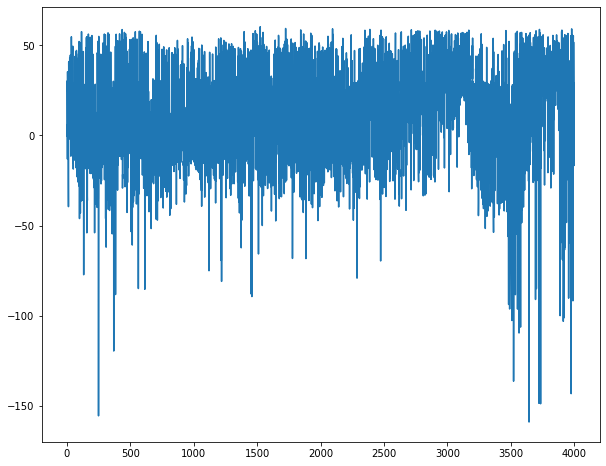

In [26]:
plt.rcParams['figure.figsize']=[10,8]
plt.plot(rewards)

In [31]:
for i,r in enumerate (R_series):
    if(r==50):
        print(i)

In [35]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[ 0.09047172,  0.25661922,  0.20194772, ..., -0.4922496 ,
         -0.23359802,  0.19640231],
        [ 0.29576042,  0.12504669,  0.6223247 , ...,  0.07863111,
         -0.5159562 , -0.8503657 ],
        [ 0.74245155, -0.25886938, -0.67433935, ...,  0.16143976,
         -0.23025873,  0.6107893 ],
        ...,
        [-0.01337622,  0.06005229, -0.49215636, ...,  0.6033547 ,
          0.52282506, -0.6593423 ],
        [ 0.8477105 , -0.17017713, -0.2840172 , ..., -0.00846833,
          0.13346188,  0.05373141],
        [ 0.30451962, -0.5277282 ,  0.5221104 , ...,  0.6110677 ,
          0.46754372,  0.6095031 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([-1.08080648e-01,  1.88367330e-02, -1.35884481e-03,  1.92353930e-02,
         2.65624654e-02, -3.07722837e-02,  1.50915030e-02, -7.38262851e-03,
         1.22613469e-02, -1.00831613e-01,  3.96741135e-03, -6.95020333e-0

In [36]:
dqn_solver.model.Qtarget.weights

[<tf.Variable 'dense_4/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[ 0.09050164,  0.2566601 ,  0.20192537, ..., -0.49223688,
         -0.23361892,  0.19642234],
        [ 0.29588962,  0.12503402,  0.62240416, ...,  0.07863744,
         -0.5159829 , -0.8502178 ],
        [ 0.7424309 , -0.258907  , -0.6743202 , ...,  0.16142936,
         -0.23024604,  0.610777  ],
        ...,
        [-0.01336132,  0.06001294, -0.49214485, ...,  0.60335153,
          0.52282274, -0.6593251 ],
        [ 0.8477235 , -0.17014176, -0.2840319 , ..., -0.00844525,
          0.13346264,  0.05372997],
        [ 0.30450943, -0.5276858 ,  0.52212626, ...,  0.6110322 ,
          0.46754253,  0.6094917 ]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(512,) dtype=float32, numpy=
 array([-1.08031504e-01,  1.88087150e-02, -1.33589178e-03,  1.93266682e-02,
         2.66580917e-02, -3.07758842e-02,  1.51892193e-02, -7.33626401e-03,
         1.22713093e-02, -1.00799672e-01,  3.95029318e-03, -6.8650282

In [42]:
S_series

[array([[-0.00549259,  1.4067907 , -0.5565959 , -0.18354535,  0.0065788 ,
          0.13013078,  0.        ,  0.        ]], dtype=float32),
 array([[-5.2222633,  0.4049908,  5.4156365,  3.1713572,  3.645967 ,
          4.8851695, -1.0158068, -3.6533897]], dtype=float32),
 array([[-7.112486  ,  0.41091335, 10.206776  ,  2.4202075 ,  6.064322  ,
          6.9321575 , -3.6094258 , -1.3611641 ]], dtype=float32),
 array([[-8.428797 ,  0.6082436, 12.471989 ,  2.7385228,  7.495485 ,
          8.498453 , -4.6047435, -1.2524517]], dtype=float32),
 array([[-9.267365 ,  0.4363724, 14.076121 ,  2.7853496,  8.098222 ,
          9.231797 , -5.3977065, -1.0793519]], dtype=float32),
 array([[-10.067233 ,   0.4838475,  15.066977 ,   2.8530502,   8.726334 ,
           9.711761 ,  -5.9134545,  -0.9734929]], dtype=float32),
 array([[-10.324633  ,   0.41854084,  15.480087  ,   2.854578  ,
           9.02002   ,   9.908846  ,  -6.071735  ,  -0.9204975 ]],
       dtype=float32),
 array([[-10.468637  ,   0.41

In [47]:
U_series

[array([[3.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([

In [43]:
S_actual_series

[array([-0.00549259,  1.4067907 , -0.5565959 , -0.18354535,  0.0065788 ,
         0.13013078,  0.        ,  0.        ], dtype=float32),
 array([-0.01091166,  1.4020762 , -0.546943  , -0.2095669 ,  0.0115569 ,
         0.09957207,  0.        ,  0.        ], dtype=float32),
 array([-0.01632118,  1.3967619 , -0.5461885 , -0.23624438,  0.01673517,
         0.10357497,  0.        ,  0.        ], dtype=float32),
 array([-0.02171392,  1.3914812 , -0.5447768 , -0.23476677,  0.0221762 ,
         0.10883079,  0.        ,  0.        ], dtype=float32),
 array([-0.02701569,  1.3856015 , -0.53388083, -0.26137123,  0.02584287,
         0.07334037,  0.        ,  0.        ], dtype=float32),
 array([-0.03240233,  1.3799659 , -0.5421614 , -0.25053626,  0.02930924,
         0.06933342,  0.        ,  0.        ], dtype=float32),
 array([-0.03777371,  1.3737303 , -0.54084295, -0.27721298,  0.03297666,
         0.07335524,  0.        ,  0.        ], dtype=float32),
 array([-0.04312859,  1.3668952 , -0.5393

In [38]:
for x in dqn_solver.memory :
    if(x[2]>10):
        print(x)

[array([[-1.168431  , -0.14622986,  2.0032084 , -0.08582126,  1.0331932 ,
         0.9798857 , -1.2902915 ,  0.30823317]], dtype=float32), 0.0, 19.60356334822816, array([[-2.0533402, -0.4515453,  1.9105127, -0.8252842,  0.5246682,
        -0.3008322, -2.1330419,  1.3394601]], dtype=float32), False]
[array([[-2.0533402, -0.4515453,  1.9105127, -0.8252842,  0.5246682,
        -0.3008322, -2.1330419,  1.3394601]], dtype=float32), 0.0, 29.58621170861598, array([[-0.00388002,  1.4032588 , -0.39324623, -0.34050548,  0.00471593,
         0.09324519,  0.        ,  0.        ]], dtype=float32), True]
[array([[-4.555787  , -0.1620419 ,  6.2933693 ,  0.52952904,  3.2270422 ,
         2.5899124 , -2.379121  , -0.14864376]], dtype=float32), 0.0, 19.6419898821655, array([[-4.9719095 , -0.77276057,  6.002187  , -0.09700017,  2.5568483 ,
         1.1078998 , -3.3242645 ,  0.8407719 ]], dtype=float32), False]
[array([[-4.818789  , -0.75039446,  5.051313  , -0.5824309 ,  2.490894  ,
         0.68822867,

In [54]:
env_render= gym.make(
        "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = True,
        wind_power  = 5.0,
        turbulence_power = 0.5,
        render_mode="human"
    )

TypeError: __init__() got multiple values for argument 'render_mode'

In [49]:
main_list=data_collection_over_eps(10,env_render,dqn_solver,autoencoder)

In [57]:
main_list[5][2]

[array([[0., 0., 0., 0., 0.]]),
 array([[-1.0404587e-03,  1.3902090e+00, -5.4595969e-04,  0.0000000e+00,
          0.0000000e+00]], dtype=float32),
 array([[-0.00149717,  1.3789731 , -0.00344978,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.00206022,  1.3671331 , -0.00437587,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.00274534,  1.3546855 , -0.00293083,  0.        ,  0.        ]],
       dtype=float32),
 array([[-3.5180091e-03,  1.3416468e+00,  4.8710917e-06,  0.0000000e+00,
          0.0000000e+00]], dtype=float32),
 array([[-0.00431671,  1.3280082 ,  0.00287798,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.00514174,  1.3137696 ,  0.00569312,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.00599365,  1.2989311 ,  0.00845403,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.00687256,  1.2834927 ,  0.01116479,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.00777893,  1.2674544 ,  0.01382

In [50]:
env_render.close()